In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
%load_ext autoreload
%autoreload 2
from python.detector.cascades import CascadesEffectiveArea, CascadesEnergyResolution
from python.detector.cascades import CascadesAngularResolution
from python.detector.northern_tracks import NorthernTracksEffectiveArea
from python.detector.northern_tracks import NorthernTracksEnergyResolution
from python.detector.northern_tracks import NorthernTracksAngularResolution
from python.backend.stan_generator import StanGenerator

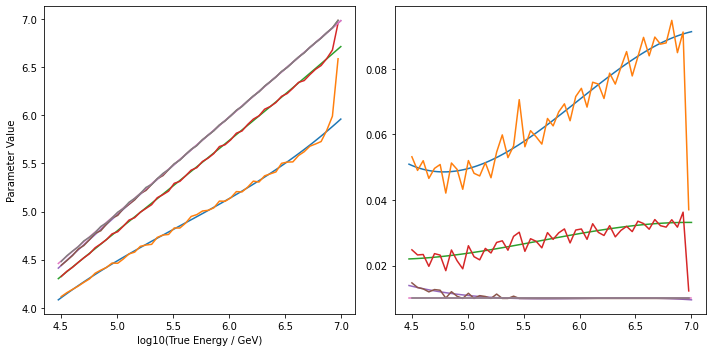

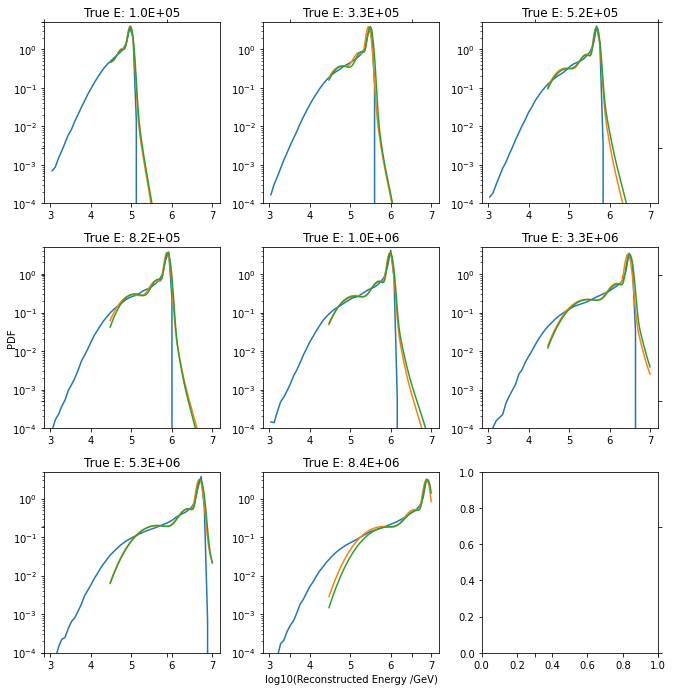

In [2]:
with StanGenerator():
    aeff = CascadesEffectiveArea()
    #aeff = NorthernTracksEffectiveArea()
    
    eres = CascadesEnergyResolution()
    #eres = NorthernTracksEnergyResolution()
    
    #ares = NorthernTracksAngularResolution()
    #ares = CascadesAngularResolution()

In [3]:
aeff.set_energy_range(3e4*u.GeV, 1e8*u.GeV)

In [4]:
aeff.set_cosz_range(-0.8, 0.0)

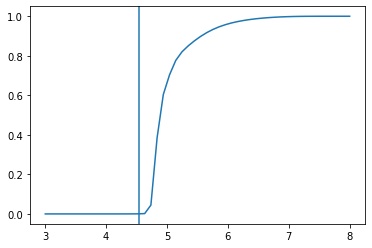

In [5]:
Egrid = 10**np.linspace(3, 8) * u.GeV
P = eres.prob_Edet_above_threshold(Egrid, 6e4 * u.GeV)
fig, ax = plt.subplots()
ax.plot(np.log10(Egrid.value), P)
ax.axvline(np.log10(3.5e4))

#### Eres parametrisation

In [6]:
import numpy as np
import h5py
from scipy.stats import norm, skewnorm
from scipy.optimize import curve_fit

In [8]:
with h5py.File("python/detector/input/cascades/cascade_detector_model.h5", "r") as f:
    eres = f["eres/eres"][()]
    tE_bins = f["eres/tE_bin_edges"][()]
    rE_bins = f["eres/rE_bin_edges"][()]
rE_binc = 0.5 * (rE_bins[:-1] + rE_bins[1:]) 

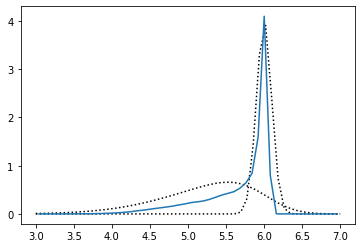

In [10]:
x = np.linspace(3, 7)
fig, ax = plt.subplots()
ax.plot(x, norm(loc=6, scale=0.1).pdf(x), color='k', linestyle=':')
ax.plot(x, skewnorm(loc=6, a=-3).pdf(x), color='k', linestyle=':')
ax.plot(np.log10(rE_binc), eres[30])

In [11]:
def my_fit_func(x, loc, scale, a, w):
    t = loc*1.03
    n = np.zeros_like(x)
    n[x<=t] = norm(loc=loc, scale=scale).pdf(x[x<=t])
    n[x>t] = 0
    sn = np.zeros_like(x)
    sn[x<=t] = skewnorm(loc=loc, a=a).pdf(x[x<=t])
    sn[x>t] = 0
    return (w*n) + ((1-w)*sn)

In [12]:
i =20
p0 = [5.5, 0.1, -4, 1.0]
bounds = ([3, 0, -10, 0], [7, 10, 0, 10])
popt, pcov = curve_fit(my_fit_func, np.log10(rE_binc), eres[i], p0=p0, bounds=bounds)

(1e-05, 5.86678819078858)

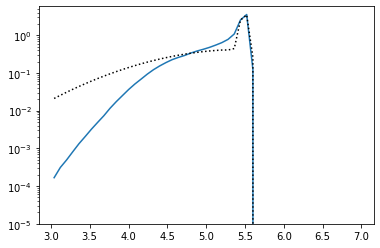

In [14]:
fig, ax = plt.subplots()
ax.plot(np.log10(rE_binc), eres[i])
ax.plot(np.log10(rE_binc), my_fit_func(np.log10(rE_binc), *popt), 
        color='k', linestyle=':')
ax.set_yscale("log")
ax.set_ylim(1e-5)